In [ ]:
import numpy as np

# 参数
q = 1  # FL 训练每个客户端都使用所有数据
T = 100 # 训练轮数
delta = 1e-4  # 隐私失败概率

# 计算不同 σ 的 ε
for sigma in [0.0005, 0.005, 0.05, 0.116, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 12.0, 14.0, 16.0, 24.0, 48.0, 64.0, 90.0, 96.0, 120.0]:
    epsilon = (q * np.sqrt(T * np.log(1/delta))) / sigma
    print(f"σ={sigma}: ε={epsilon:.4f}")

σ=0.0005: ε=60697.0852
σ=0.005: ε=6069.7085
σ=0.05: ε=606.9709
σ=0.116: ε=261.6254
σ=0.5: ε=60.6971
σ=1.0: ε=30.3485
σ=2.0: ε=15.1743
σ=3.0: ε=10.1162
σ=4.0: ε=7.5871
σ=5.0: ε=6.0697
σ=6.0: ε=5.0581
σ=7.0: ε=4.3355
σ=8.0: ε=3.7936
σ=10.0: ε=3.0349
σ=12.0: ε=2.5290
σ=14.0: ε=2.1678
σ=16.0: ε=1.8968
σ=24.0: ε=1.2645
σ=48.0: ε=0.6323
σ=64.0: ε=0.4742
σ=90.0: ε=0.3372
σ=96.0: ε=0.3161
σ=120.0: ε=0.2529


In [9]:
import numpy as np
x1 = np.load("./dataset/MNIST/iid_20_with_public/train_1_samples.npy")
print(x1[0].shape)
y1 = np.load("./dataset/MNIST/iid_20_with_public/train_1_labels.npy")
print(y1[0])

(1, 28, 28)
9


In [12]:
import pickle
ref_dir = "/home/wzj/FLattack/FedField/log/2025-04-03_14-36"
filename = ref_dir + "/res/Accurancy.pkl"
with open(filename, 'rb') as f:
    accs = pickle.load(f)
print(max(accs))

0.131


In [8]:
import pickle
ref_dir = "/home/wzj/FLattack/FedField/src/dataset/FashionMNIST/iid_10_with_public/public.pkl"
with open(ref_dir, 'rb') as f:
    test_dataset = pickle.load(f)
print(len(test_dataset))

6000


图片已保存至: ./dataset/MNIST/dirichlet_20users_a1000_seed98_public0.05/label_distribution.png


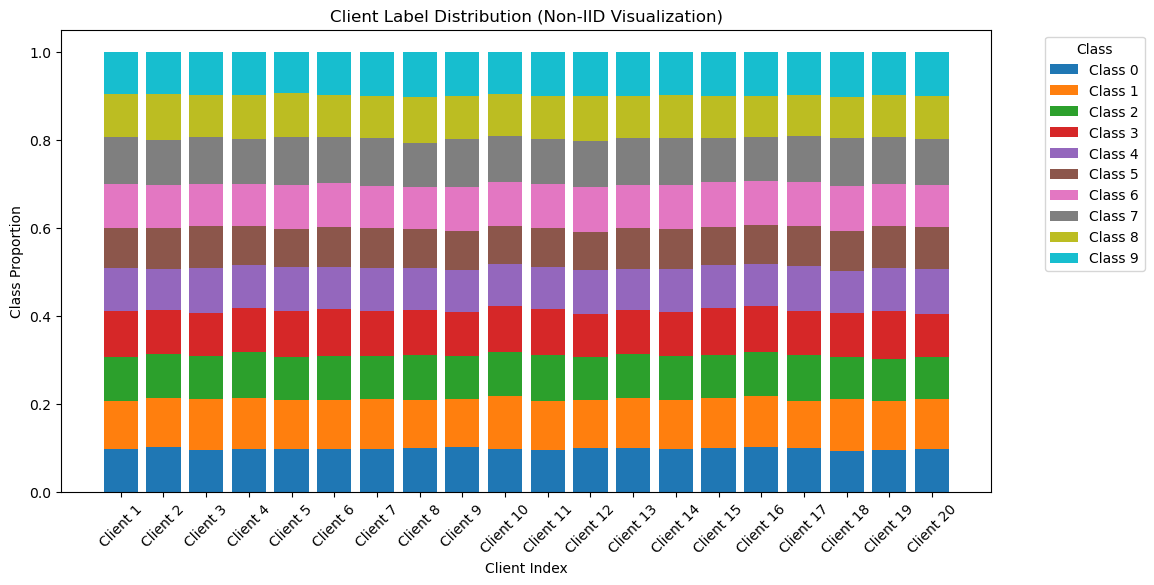

In [8]:
from result.client import plot_client_label_distribution
dir = "./dataset/MNIST/dirichlet_20users_a1000_seed98_public0.05"
plot_client_label_distribution(20, dir, dir, save_name="label_distribution.png")